# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not rerun the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [2]:
student1 = "Quentin Rebjock"
student2 = "Augustin Prado"

**Seed value fixed because the hash function depends on the operating system :**

In [3]:
hash_value = 1993331184

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
%matplotlib inline  

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
np.random.seed(hash_value)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


NameError: name 'hash_value' is not defined

Subset of class used:

In [5]:
# 1,0,9,3,4
subset_of_classes

array([1, 0, 9, 3, 4])

### Plotting

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels, loc='best')
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels, loc='best')
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_histories(history1, history2, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history1.history['loss'], label = "training 1")
    ax1.plot(history1.history['val_loss'], label = "validation 1")
    
    ax1.plot(history2.history['loss'], label = "training 2")
    ax1.plot(history2.history['val_loss'], label = "validation 2")
    
    ax2.plot(history1.history['acc'], label = "training")
    ax2.plot(history1.history['val_acc'], label = "validation")
    
    ax2.plot(history2.history['acc'], label = "training")
    ax2.plot(history2.history['val_acc'], label = "validation")
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [7]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [8]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

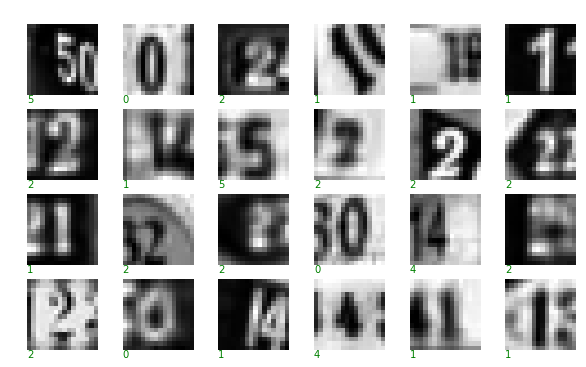

In [9]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [10]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [10]:
"""
Helper functions to save and load models and other
variables so they don't have to be calculated each time.
"""

def save_model(model, name):
    """
    Saves the parameters of the model.
    """
    model.save_weights('data/models/' + name + '.h5')
    
def load_model(model, name):
    """
    Loads the parameters for the model.
    """
    model.load_weights('data/models/' + name + '.h5')
    
import pickle

def save_obj(obj, name):
    """
    Saves an object in a pickle file.
    """
    with open('data/pickle/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    """
    Loads an object from a pickle file.
    """
    with open('data/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_history(history, name):
    """
    Save an history (as a dict object).
    """
    to_save = history.history
    save_obj(to_save, name)
    
def load_history(name):
    """
    Load a saved history (dict object).
    """
    return load_obj(name)
    
def plot_dict_history(history, title):
    """
    Same as plot_history but directly uses a dictionary instead.
    """
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_dict_histories(history1, history2, title1, title2):
    """
    Plots two histories on the same graph.
    """
    fig, ax1, ax2 = prepare_standardplot(title1 + ' versus ' + title2, 'epoch')
    ax1.plot(history1['loss'], label = "training "+title1)
    ax1.plot(history1['val_loss'], label = "validation " +title1)
    ax1.plot(history2['loss'], label = "training "+title2)
    ax1.plot(history2['val_loss'], label = "validation "+title2)
    
    ax2.plot(history1['acc'], label = "training "+title1)
    ax2.plot(history1['val_acc'], label = "validation "+title1)
    ax2.plot(history2['acc'], label = "training "+title2)
    ax2.plot(history2['val_acc'], label = "validation "+title2)
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

We use the following hyper parameters imposed by the exercise. Since the images are $16\times16$, the input shape is `input_shape = (16*16,)`.

In [69]:
"""
Parameters
"""
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 100
input_shape = (16*16,)
optimizer = SGD()

In [70]:
"""
Model architecture
"""

model1 = Sequential()
model1.add(Dense(num_classes, activation='softmax', input_shape=input_shape))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


In [72]:
"""
Training the model
"""

model1.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy']
              )

history1 = model1.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=0,
                     validation_data=(x_test, y_test),
                    )

score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss (after {} epochs):'.format(epochs), score[0])
print('Test accuracy (after {} epochs):'.format(epochs), score[1])

Test loss (after 100 epochs): 1.5255041537520886
Test accuracy (after 100 epochs): 0.38895528020770814


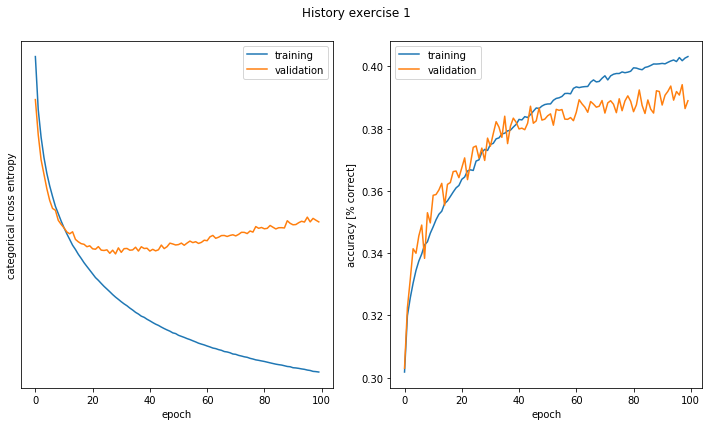

In [73]:
plot = plot_history(history1, 'History exercise 1')

The model starts overfitting after about 20-30 epochs as we can see on the previous plots : the validation error starts increasing while the training errors keeps decreasing.

To determine all the images that are misclassified, we can use the model to predict the classes of the input `x_test` and check if they coincide with `y_test`. We are plotting here some examples of misclassified images and we notice that our model seems to often predict `1` in the misclassified cases.

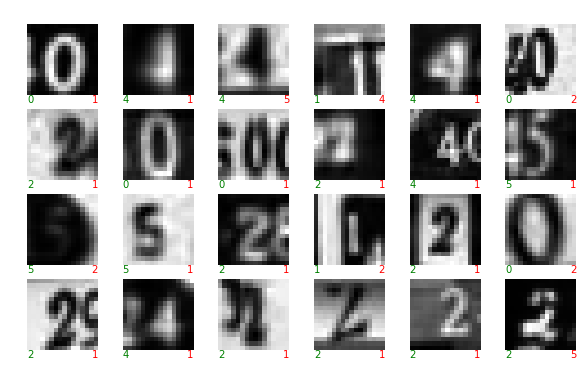

In [74]:
yhat_test = model1.predict_classes(x_test)
y_test_labels = np.argmax(y_test, axis=1)
error_indices = np.where(yhat_test != y_test_labels)[0]

a = plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

#### Question 1

We use the following hyper parameters given by the subject and create a basic model architecture.

In [60]:
"""
Parameters
"""
hidden_units = 64
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 50
input_shape = (16*16,)

In [61]:
"""
Model architecture
"""
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes,
                 activation='softmax'
                )
          )

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


The summary method allows us to see the number of trainable parameters which can be an indicator of the power of the model.

#### Question 2

We fit here the model created in the question 1.

In [62]:
"""
Fitting the same model with several learning
rates and comparing the differences.
"""

test_losses = []
test_accs = []

learning_rates = np.logspace(-5, 1, 15)

for lr in learning_rates:
    
    model2.compile(loss='categorical_crossentropy', 
                   optimizer=SGD(lr=lr), 
                   metrics=['accuracy'])

    model2.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               verbose=0,
               validation_data=(x_test, y_test)
              )
    
    score = model2.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])
    print('learning rate: ', lr)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1], '\n')

learning rate:  1e-05
Test loss: 1.5724765705952848
Test accuracy: 0.30788099880589354 

learning rate:  2.6826957952797274e-05
Test loss: 1.559975296073353
Test accuracy: 0.31536574627381914 

learning rate:  7.196856730011514e-05
Test loss: 1.547314888726646
Test accuracy: 0.3212780678030065 

learning rate:  0.00019306977288832496
Test loss: 1.52527684014176
Test accuracy: 0.3309013145480848 

learning rate:  0.0005179474679231213
Test loss: 1.4822358875441413
Test accuracy: 0.3657462733505252 

learning rate:  0.0013894954943731374
Test loss: 1.3345368951587184
Test accuracy: 0.462796402290858 

learning rate:  0.003727593720314938
Test loss: 0.9671403518434786
Test accuracy: 0.6758286684490958 

learning rate:  0.01
Test loss: 0.726822166917039
Test accuracy: 0.7792942952461922 

learning rate:  0.026826957952797246
Test loss: 0.5632070332167621
Test accuracy: 0.8372853638556133 

learning rate:  0.07196856730011514
Test loss: 0.48473833152592366
Test accuracy: 0.8681678092811863 

In [109]:
"""
Saving the lists. /!\ Do not run it unless you want to override them.
"""
save_obj(test_losses, 'ex2_losses')
save_obj(test_accs, 'ex2_accs')

Plot with respect to different learning rates

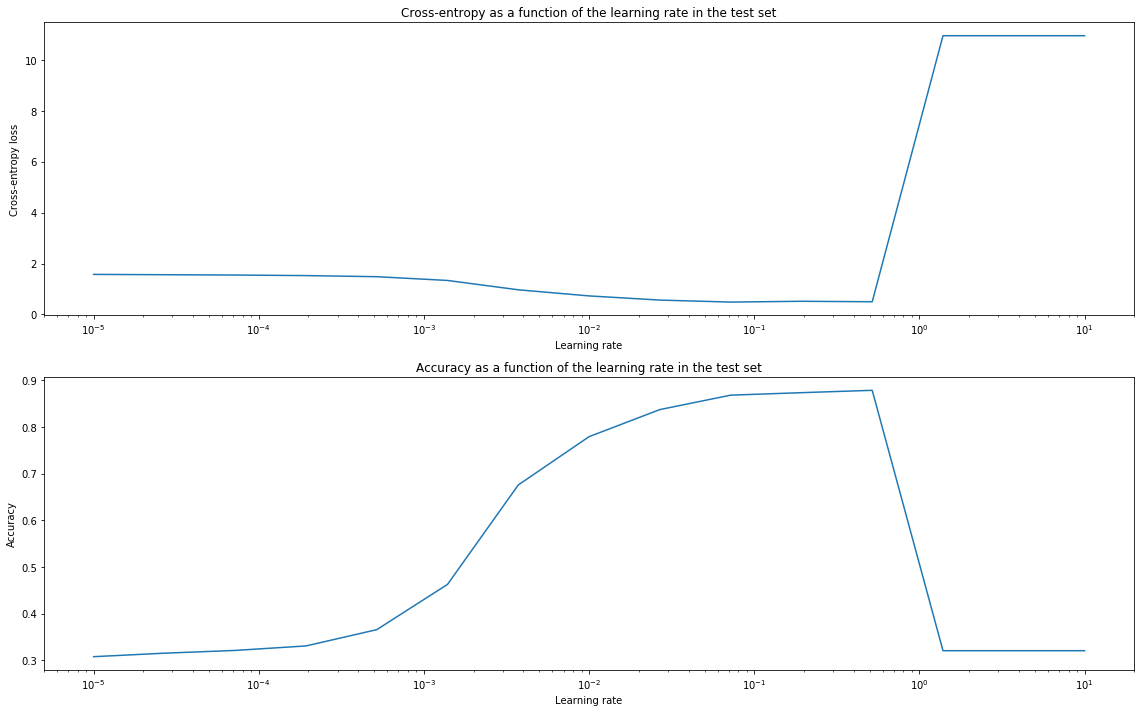

In [82]:
"""
Loading the lists.
"""
test_losses = load_obj('ex2_losses')
test_accs = load_obj('ex2_accs')

fig, ax = plt.subplots(2, 1, figsize=(16,10))

ax[0].semilogx(learning_rates, test_losses)
ax[0].set_title('Cross-entropy as a function of the learning rate in the test set')
ax[0].set_ylabel('Cross-entropy loss')
ax[0].set_xlabel('Learning rate')

ax[1].semilogx(learning_rates, test_accs)
ax[1].set_title('Accuracy as a function of the learning rate in the test set')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Learning rate')

plt.tight_layout()

plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is of order of 1 and more, we have very bad results for both loss and accuracy, since the gradient step is too large, therefore not precise enough to reach a local minimum.   

B) When the learning rate is very small (10e-4 and less), the validation accuracy is very bad (~0.4) because of the fact that the learning is very slow (due to small learning rate) and therefore need a lot more epochs to be a good classifier.

#### Question 3 : With Adam optimizer

In this section we are using Adam optimizer which can be found in `keras.optimizers`. The other hyper parameters remain the same.

In [24]:
from keras.optimizers import Adam

In [25]:
"""
Parameters
"""
hidden_units = 64
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 50
input_shape = (16*16,)
optimizer = Adam()

In [26]:
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
               optimizer = optimizer,
               metrics=['accuracy']
              )

history2_adam = model2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test)
          )

score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1], '\n')

Test loss: 0.45909753598423225
Test accuracy: 0.8842065538825595 



We achieve with Adam optimizer a better loss and accuracy, compared to the best result of the SGD optimizer for the same number of iterations (50 epochs)

- Loss: 0.45 (Adam) vs 0.47 (SGD)
- Accuracy: 0.88 (Adam) vs 0.87 (SGD)


In [27]:
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
               optimizer = SGD(lr=0.1),
               metrics=['accuracy']
              )

history2_sgd = model2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test)
          )

#### Question 4

We plot here the learning curves with SGD and Adam optimizer so we can compare their performances. It turns out that Adam optimizer is doing a little better than SGD for every single epoch in term of loss and of accuracy.

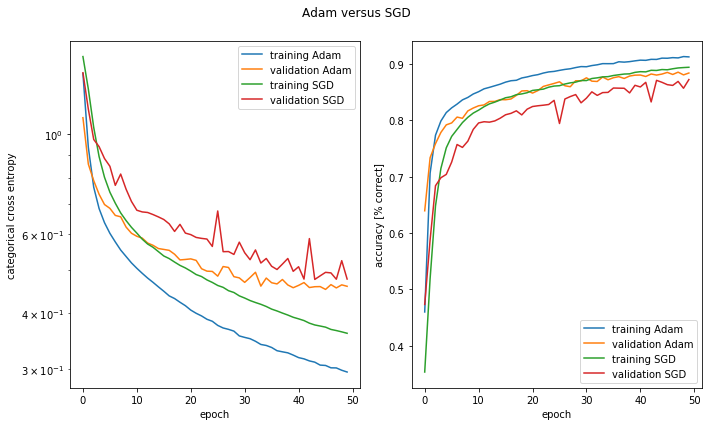

In [31]:
plot = plot_dict_histories(history2_adam.history, history2_sgd.history, 'Adam', 'SGD')

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In order to use early stopping, we check where the validation loss is minimal and we take the corresponding validation accuracy.

In [60]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=input_shape))
model2.add(Dense(5, activation='softmax'))

optimizer = Adam()
model2.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=400,
                    verbose=0,
                    validation_data=(x_test, y_test))

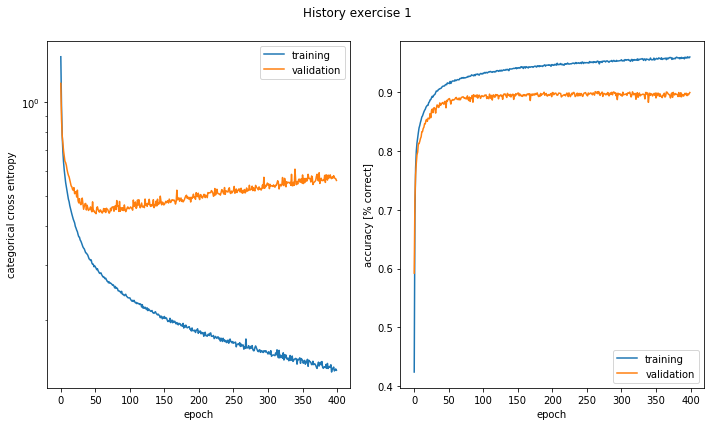

In [61]:
a = plot_history(history, 'History exercise 1')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model starts overfitting at the epoch 50-60 approximately, when the validation loss starts increasing.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: We can detect a model is overfitting by looking at its validation loss curve and not accuracy curve, because loss curve is a more precise indicator than accuracy. Error curve show how close are our predictions to the true values using an entropy-based score, means considering a probability model. While accuracy stagnate, meaning predictions get worse but the scores don't cross the threshold where the predicted class changes.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

#### Question 1

Using 90 epochs is enough to go beyond the point of overfitting.

In [35]:
"""
Parameters
"""
hidden_units = [100, 200, 350, 500, 650, 800, 900, 1000]
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 90
input_shape = (16*16,)
optimizer = Adam()

In [1]:
test_losses= []
test_accs= []

for nb_neurons in hidden_units:
    models = Sequential()
    models.add(Dense(nb_neurons, activation='relu', input_shape=input_shape))
    models.add(Dense(num_classes, activation='softmax'))
    
    models.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy']
                  )

    history = models.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               verbose=0,
               validation_data=(x_test, y_test)
              )
    score = models.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])

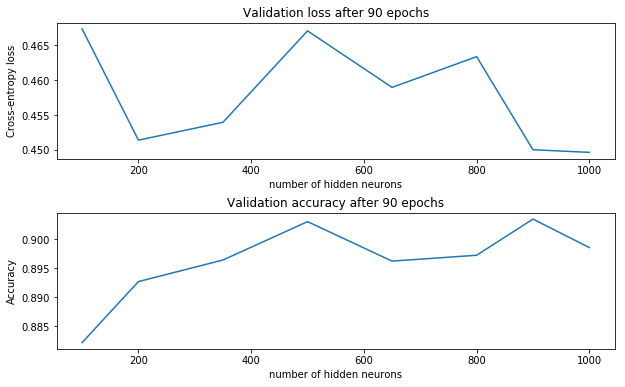

In [59]:
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.plot(hidden_units, test_losses)
plt.title('Validation loss after 90 epochs')
plt.ylabel('Cross-entropy loss')
plt.xlabel('number of hidden neurons')

plt.subplot(2,1,2)
plt.plot(hidden_units, test_accs)
plt.title('Validation accuracy after 90 epochs')
plt.ylabel('Accuracy')
plt.xlabel('number of hidden neurons')
plt.show()

Looking at the validation loss, the best number of hidden neurons seems to be either ~200 or ~900. Looking at the accuracy we would choose 900 hidden neurons, but let's do more runs for robust results and let's consider that we may be overfitting !

#### Question 2

We collect more data with more runs (6 here) for each set of parameters.

In [5]:
for i in range(len(hidden_units)):
    print('Processing for ', hidden_units[i] ,' neurons ...' )
    histories.append([])
    for j in range(6):
        if(j%3==0):
            print(j)
        models = Sequential()
        models.add(Dense(hidden_units[i], activation='relu', input_shape=input_shape))
        models.add(Dense(num_classes, activation='softmax'))

        models.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = models.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   validation_data=(x_test, y_test)
                  )
        histories[i].append(history.history)

#### Question 3

We plot here the losses and accuracies at the very last epoch, without early stopping.

In [29]:
"""
Saving & load the model. /!\ Do not run save unless you want to override it.
"""
#save_obj(histories, 'ex4_histories')
histories = load_obj('ex4_histories')

In [40]:
histories_loss =[]
histories_acc =[]
for i in range(len(histories)):
    histories_loss.append([])
    histories_acc.append([])
    for j in range(len(histories[0])):
        histories_loss[i].append(histories[i][j]['val_loss'])
        histories_acc[i].append(histories[i][j]['val_acc'])
histories_loss = np.array(histories_loss)
histories_acc = np.array(histories_acc)

final_val_loss = histories_loss[:,:,-1]
final_val_acc = histories_acc[:,:,-1]
val_loss = np.min(histories_loss, axis=2)
val_acc = []
for (j, i) in enumerate(np.argmin(histories_loss, axis=2)):
    val_acc.append(np.diag(np.take(histories_acc[j],i.tolist(), axis=1)).tolist())
val_acc = np.array(val_acc)

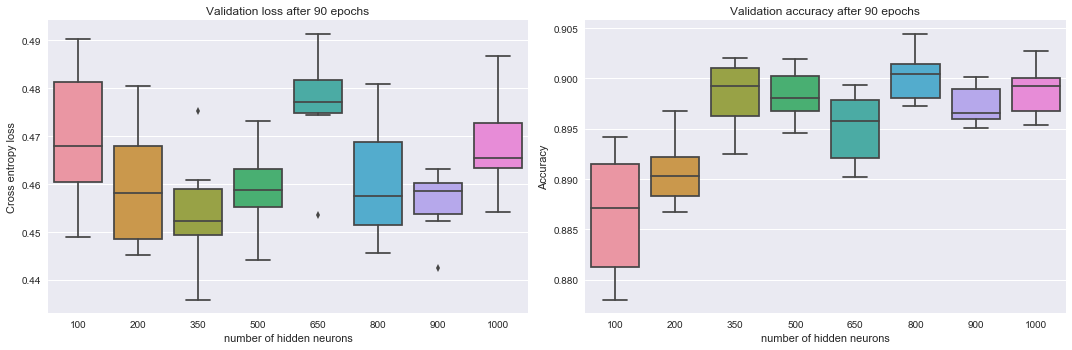

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=final_val_loss.T, ax=ax[0])
ax[0].set_title('Validation loss after 90 epochs')
ax[0].set_ylabel('Cross entropy loss')
ax[0].set_xlabel('number of hidden neurons')
ax[0].set_xticklabels(hidden_units, fontsize=10)

sns.boxplot(data=final_val_acc.T, ax=ax[1])
ax[1].set_title('Validation accuracy after 90 epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('number of hidden neurons')
ax[1].set_xticklabels(hidden_units, fontsize=10)

plt.tight_layout()

plt.show()

We get similar result as in the last point (with one run). The model with 800 hidden neurons seems to give the best validation accuracy.

#### Question 4

Let's see results with early stopping...

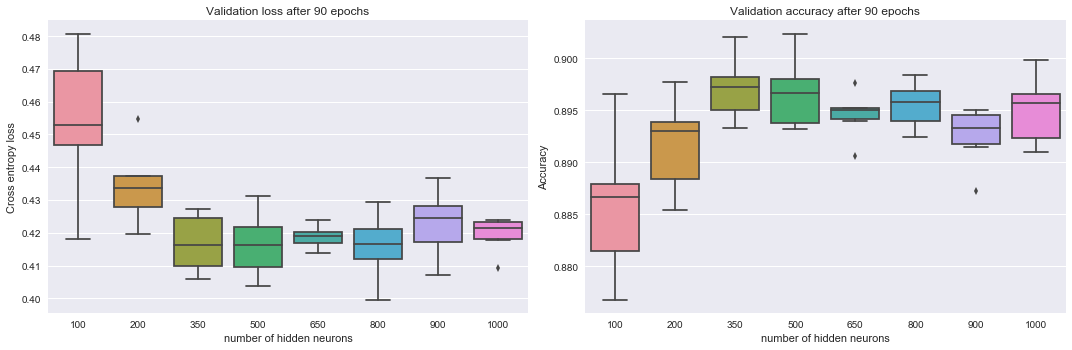

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=val_loss.T, ax=ax[0])
ax[0].set_title('Validation loss with early stopping')
ax[0].set_ylabel('Cross entropy loss')
ax[0].set_xlabel('number of hidden neurons')
ax[0].set_xticklabels(hidden_units, fontsize=10)

sns.boxplot(data=val_acc.T, ax=ax[1])
ax[1].set_title('Validation accuracy with early stopping')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('number of hidden neurons')
ax[1].set_xticklabels(hidden_units, fontsize=10)

plt.tight_layout()

plt.show()

We finally found out that all the models were overfitting with a new validation loss of ~0.42 against ~0.47. Models are still almost equivalent. We can choose ~500 hidden neurons having the best validation loss and accuracy mean. We could also choose 650 hidden neurons, which has worse scores in average but a lower variance, then more stable. (bias/variance tradeoff)  

We save here history ouf our best model (with 500 neurons) for further comparisons : 

In [103]:
models = Sequential()
models.add(Dense(500, activation='relu', input_shape=input_shape))
models.add(Dense(num_classes, activation='softmax'))
    
models.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy']
                  )

history = models.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=90,
               verbose=0,
               validation_data=(x_test, y_test)
              )

In [108]:
save_history(history, 'ex_4_500_neurons')

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

**Question 1**

Let a network with $N_{in}$ inputs, $K$ hidden layers with $N_h$ units, and one output layer with $N_{out}$ dimensions. Let's calculate the number of parameters $N_p$. First consider $K = 1$. Then

$N_p = (N_{in} + 1)*N_h + (N_h + 1)*N_{out} = N_h * (N_{in} + N_{out} + 1) + N_{out}$

Each time another hidden layer with $N_h$ units is added, $N_h * (N_h + 1)$ parameters additional parameters appear.

So for any $K \geq 1$,

$N_p = N_h * (N_{in} + N_{out} + 1) + N_{out} + (K - 1) * N_h * (N_h + 1)$

$N_p = (K - 1) * N_h^{2} + (N_{in} + N_{out} + K) * N_h + N_{out}$

We get a quadratic equation that can be solved.

We calculate the number of parameters in a network with 1 hidden layers of 100 neurons.

In [71]:
N_in = 16*16
K = 1
N_h = 100
N_out = 5

N_p = (K - 1) * N_h * N_h + (N_in + N_out + K) * N_h + N_out

print('There are {} parameters in a network with one hidden layer of 100 neurons.'.format(N_p))

There are 26205 parameters in a network with one hidden layer of 100 neurons.


Then with the quadratic equation that we found previously, we can calculate the number of neurons required for each model (with 2, 3 and 4 hidden layers) to have the same number of parameters.

In [72]:
K_list = [2, 3, 4]
N_h_list = []

for K in K_list:
    a = K - 1
    b = N_in + N_out + K
    c = N_out - N_p
    N_h_list.append(((-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)).astype(int))
    
N_h_2 = N_h_list[0]
N_h_3 = N_h_list[1]
N_h_4 = N_h_list[2]

print('The numbers of hidden units that approximate the best the number of parameters are '
      '{0}, {1} and {2} for respectively 2, 3 and 4 hidden layers.'.format(N_h_2, N_h_3, N_h_4))

The numbers of hidden units that approximate the best the number of parameters are 77, 66 and 59 for respectively 2, 3 and 4 hidden layers.


We create the 4 different models which have approximately the same number of parameters, as it can be checked below :

In [13]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 70
input_shape = (16*16,)
optimizer = Adam()
num_runs = 5

In [27]:
"""
Model with 1 hidden layer
"""

model1 = Sequential()

model1.add(Dense(N_h,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model1.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 2 hidden layers
"""

model2 = Sequential()

model2.add(Dense(N_h_2,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(N_h_2,
                 activation='relu'
                )
          )

model2.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 3 hidden layers
"""

model3 = Sequential()

model3.add(Dense(N_h_3,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model3.add(Dense(N_h_3,
                 activation='relu'
                )
          )

model3.add(Dense(N_h_3,
                 activation='relu'
                )
          )

model3.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 4 hidden layers
"""

model4 = Sequential()

model4.add(Dense(N_h_4,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu'
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu'
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu'
                )
          )

model4.add(Dense(N_out,
                 activation='softmax'
                )
          )

models = [model1, model2, model3, model4]

model1.summary()

model2.summary()

model3.summary()

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_25 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

All of them have a number of parameters around 26,150 (from 26,083 to 26,205). We cannot make them have exactly the same number of parameters because adding one single neuron to each layer increases the number of parameters by a large amount.

**Question 2**

We train `num_runs` times each model with an Adam optimizer over `70` epochs and compare the results using early stopping. We can then average the best accuracy over the several runs and calculate the standard deviation (box plots are useful to visualize this).

In [65]:
loss_scores = []
accuracy_scores = []

for i, model in enumerate(models):
    loss_scores.append([])
    accuracy_scores.append([])
    for j in range(num_runs):
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        loss_scores[i].append(history.history['val_loss'])
        accuracy_scores[i].append(history.history['val_acc'])

In [67]:
"""
Saving the lists. /!\ Do not run it unless you want to override them.
"""
save_obj(loss_scores, 'ex5_losses')
save_obj(accuracy_scores, 'ex5_accs')

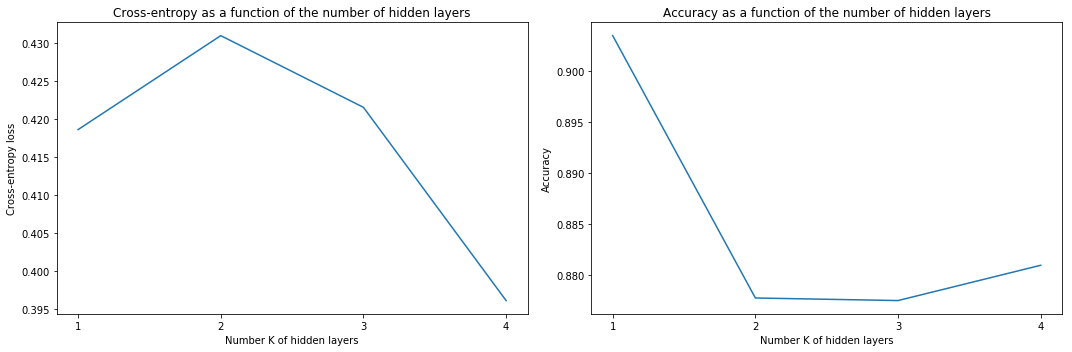

In [43]:
"""
Loading the lists.
"""
loss_history = np.array(load_obj('ex5_losses'))
accuracy_history = np.array(load_obj('ex5_accs'))

loss_scores = np.min(loss_history, axis=(1, 2))
accuracy_scores = []
for (j, i) in enumerate(np.argmin(loss_history, axis=2)):
    accuracy_scores.append(np.diag(np.take(accuracy_history[j],i.tolist(), axis=1)).tolist())
accuracy_scores = np.max(accuracy_scores, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(['1', '2', '3', '4'], loss_scores)
ax[0].set_title('Cross-entropy as a function of the number of hidden layers')
ax[0].set_ylabel('Cross-entropy loss')
ax[0].set_xlabel('Number K of hidden layers')

ax[1].plot(['1', '2', '3', '4'], accuracy_scores)
ax[1].set_title('Accuracy as a function of the number of hidden layers')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number K of hidden layers')

plt.tight_layout()

plt.show()

This plot gives the minimum validation loss over all the runs and the corresponding best accuracy. The model with only 1 hidden layer is doing better than the other ones (the laters having very close accuracies).

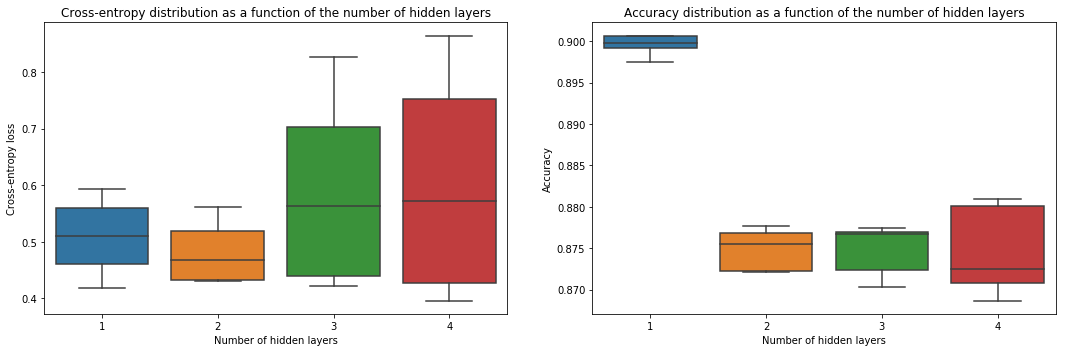

In [38]:
loss_history = np.array(load_obj('ex5_losses'))
accuracy_history = np.array(load_obj('ex5_accs'))

loss_scores = np.min(loss_history, axis=2)
accuracy_scores = []
for (j, i) in enumerate(np.argmin(loss_history, axis=2)):
    accuracy_scores.append(np.diag(np.take(accuracy_history[j],i.tolist(), axis=1)).tolist())
accuracy_scores = np.array(accuracy_scores)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=loss_scores.T, ax=ax[0])
ax[0].set_title('Cross-entropy distribution as a function of the number of hidden layers')
ax[0].set_ylabel('Cross-entropy loss')
ax[0].set_xlabel('Number of hidden layers')
ax[0].set_xticklabels([1, 2, 3, 4], fontsize=10)

sns.boxplot(data=accuracy_scores.T, ax=ax[1], showfliers=False)
ax[1].set_title('Accuracy distribution as a function of the number of hidden layers')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of hidden layers')
ax[1].set_xticklabels([1, 2, 3, 4], fontsize=10)

plt.tight_layout()

plt.show()

This box plots allow us to see the variance of each model better.

It seems like all the models with strictly more than 1 hidden layer give pretty much the same accuracies (about 87.5%) with a little noise but are less accurate than the model with 1 hidden layer (about 90%).

A possible interpretation is that it could be expected from the fact that the number of trainable parameters is actually decreasing as the number of layers increase. We indeed tried to make the 4 models have the same number of parameters but it was impossible to get exactly the same number.

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

We are first trying to see how batch normalisation, dropout and regularization improve (or not) the results independently of others. Since we can't try all possible combinations, we then use the best tricks (with the best parameters for each other them) in a final network and see if it is more accurate than the baseline.

We define the following two function `create_model1` and `create_model4` which create the models with 1 and 4 layers respectively, and where batch_normalisation, dropout and regularisation can be added with the parameters.

In [94]:
from keras.layers import BatchNormalization
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

"""
Model with 1 hidden layer
"""

def create_model1(bn=False, dropout=0, l1_rate=0, l2_rate=0):
    reg = None
    if l1_rate > 0 and l2_rate > 0: reg = l1_l2((l1_rate + l2_rate)/2)
    elif l1_rate > 0: reg = l1(l1_rate)
    elif l2_rate > 0: reg = l2(l2_rate)
        
    model1 = Sequential()
    model1.add(Dense(N_h,
                     activation='relu',
                     input_shape=input_shape,
                     kernel_regularizer=reg,
                     bias_regularizer=reg
                    )
              )
    if bn:
        model1.add(BatchNormalization())
    if dropout > 0:
        model1.add(Dropout(dropout))
    model1.add(Dense(N_out,
                     activation='softmax'
                    )
              )
    
    return model1

"""
Model with 4 hidden layers
"""

def create_model4(bn=False, dropout=0, l1_rate=0, l2_rate=0):
    reg = None
    if l1_rate > 0 and l2_rate > 0: reg = l1_l2((l1_rate + l2_rate)/2)
    elif l1_rate > 0: reg = l1(l1_rate)
    elif l2_rate > 0: reg = l2(l2_rate)
    
    model4 = Sequential()
    model4.add(Dense(N_h_4,
                     activation='relu',
                     input_shape=input_shape,
                     kernel_regularizer=reg,
                     bias_regularizer=reg
                    )
              )
    if bn:
        model4.add(BatchNormalization())
    if dropout > 0:
        model4.add(Dropout(dropout))
    model4.add(Dense(N_h_4,
                     activation='relu',
                     kernel_regularizer=reg,
                     bias_regularizer=reg
                    )
              )
    if bn:
        model4.add(BatchNormalization())
    if dropout > 0:
        model4.add(Dropout(dropout))
    model4.add(Dense(N_h_4,
                     activation='relu',
                     kernel_regularizer=reg,
                     bias_regularizer=reg
                    )
              )
    if bn:
        model4.add(BatchNormalization())
    if dropout > 0:
        model4.add(Dropout(dropout))
    model4.add(Dense(N_h_4,
                     activation='relu',
                     kernel_regularizer=reg,
                     bias_regularizer=reg
                    )
              )
    if bn:
        model4.add(BatchNormalization())
    if dropout > 0:
        model4.add(Dropout(dropout))
    model4.add(Dense(N_out, activation='softmax'))
    
    return model4

#### Baseline results

In this section we create two baseline models (1 hidden layer and 4 hidden layer) without any trick and train them `num_runs = 5` times to get more robust statistics. For each run, we keep only the best accuracy (early stopping). The results will be useful to see how good the tricks are performing later.

In [18]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 200
input_shape = (16*16,)
optimizer = Adam()
num_runs = 5 #Averaging the results over 5 runs

**Training the models :**

In [54]:
histories1 = []

for j in range(num_runs):
    model = create_model1()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                        validation_data=(x_test, y_test))        
    histories1.append(history.history)
        
histories4 = []

for j in range(num_runs):
    model = create_model4()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                        validation_data=(x_test, y_test)
                       )
    histories4.append(history.history)

In [55]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_obj(histories1, 'ex6_baseline_histories1')
save_obj(histories4, 'ex6_baseline_histories4')

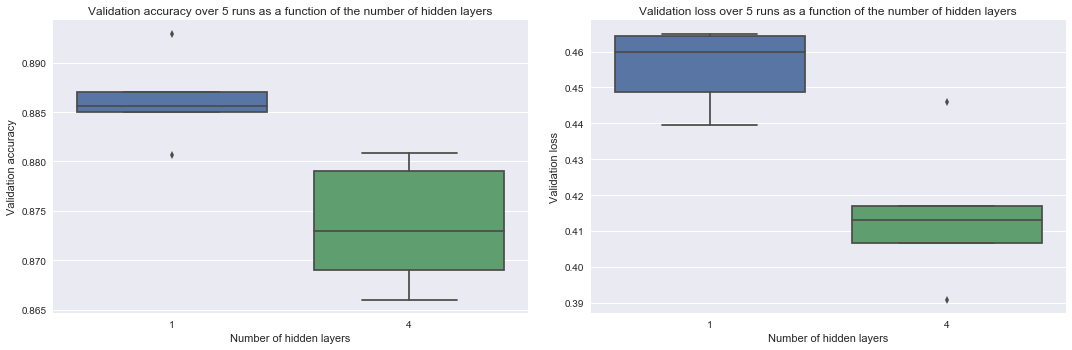

In [83]:
histories1 = load_obj('ex6_baseline_histories1')
histories4 = load_obj('ex6_baseline_histories4')

histories1_loss =[]
histories1_acc =[]
histories4_loss =[]
histories4_acc =[]

for i in range(len(histories1)):
    histories1_acc.append(histories1[i]['val_acc'])
    histories1_loss.append(histories1[i]['val_loss'])

histories1_acc = np.array(histories1_acc)
histories1_loss = np.array(histories1_loss)

for i in range(len(histories1)):
    histories4_acc.append(histories4[i]['val_acc'])
    histories4_loss.append(histories4[i]['val_loss'])

histories4_acc = np.array(histories4_acc)
histories4_loss = np.array(histories4_loss)

val_loss1_baseline = np.min(histories1_loss, axis=1)

val_acc1_baseline = []
for (j, i) in enumerate(np.argmin(histories1_loss, axis=1)):
    val_acc1_baseline.append(histories1_acc[j][i])
val_acc1_baseline = np.array(val_acc1_baseline)

val_loss4_baseline = np.min(histories4_loss, axis=1)
val_acc4_baseline = []
for (j, i) in enumerate(np.argmin(histories4_loss, axis=1)):
    val_acc4_baseline.append(histories4_acc[j][i])
val_acc4_baseline = np.array(val_acc4_baseline)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_baseline.T, val_acc4_baseline.T], ax=ax[0])
ax[0].set_title('Validation accuracy over 5 runs as a function of the number of hidden layers')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Number of hidden layers')
ax[0].set_xticklabels([1, 4], fontsize=10)

sns.boxplot(data=[val_loss1_baseline.T, val_loss4_baseline.T], ax=ax[1])
ax[1].set_title('Validation loss over 5 runs as a function of the number of hidden layers')
ax[1].set_ylabel('Validation loss')
ax[1].set_xlabel('Number of hidden layers')
ax[1].set_xticklabels([1, 4], fontsize=10)

plt.tight_layout()

plt.show()

In [84]:
print('On average, the model with 1 hidden layer performs {0}% accuracy and the model with 4 hidden '
      'layers performs {1}% accuracy.'
      .format(np.round(100*np.mean(val_acc1_baseline), 3), np.round(100*np.mean(val_acc4_baseline), 3)))

On average, the model with 1 hidden layer performs 88.626% accuracy and the model with 4 hidden layers performs 87.359% accuracy.


#### Only batch normalization

In this section we check how the batch normalization affects the results. For both models, we average the results over `num_runs = 5` runs and plot them.

In [49]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 200
input_shape = (16*16,)
optimizer = Adam()
num_runs = 5 #Averaging the results over 5 runs

In [51]:
histories1_bn = []

for j in range(num_runs):
    model = create_model1(bn=True)
        
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy']
                 )

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test)
                       )
        
    histories1_bn.append(history.history)
        
histories4_bn = []

for j in range(num_runs):
    model = create_model4(bn=True)
        
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy']
                 )

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test)
                       )
        
    histories4_bn.append(history.history)

In [52]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_obj(histories1_bn, 'ex6_bn_histories1')
save_obj(histories4_bn, 'ex6_bn_histories4')

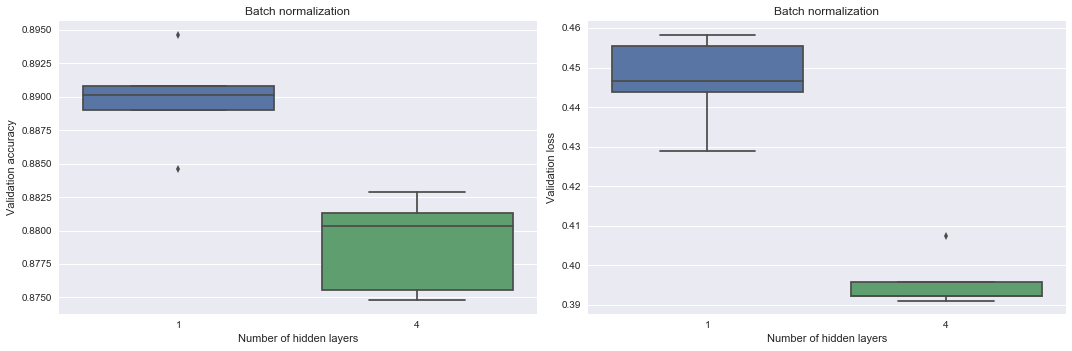

In [45]:
histories1 = load_obj('ex6_bn_histories1')
histories4 = load_obj('ex6_bn_histories4')

histories1_loss =[]
histories1_acc =[]
histories4_loss =[]
histories4_acc =[]

for i in range(len(histories1)):
    histories1_acc.append(histories1[i]['val_acc'])
    histories1_loss.append(histories1[i]['val_loss'])

histories1_acc = np.array(histories1_acc)
histories1_loss = np.array(histories1_loss)

for i in range(len(histories1)):
    histories4_acc.append(histories4[i]['val_acc'])
    histories4_loss.append(histories4[i]['val_loss'])

histories4_acc = np.array(histories4_acc)
histories4_loss = np.array(histories4_loss)

val_loss1_bn = np.min(histories1_loss, axis=1)
val_acc1_bn = []
for (j, i) in enumerate(np.argmin(histories1_loss, axis=1)):
    val_acc1_bn.append(histories1_acc[j][i])
val_acc1_bn = np.array(val_acc1_bn)

val_loss4_bn = np.min(histories4_loss, axis=1)
val_acc4_bn = []
for (j, i) in enumerate(np.argmin(histories4_loss, axis=1)):
    val_acc4_bn.append(histories4_acc[j][i])
val_acc4_bn = np.array(val_acc4_bn)


fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_bn.T, val_acc4_bn.T], ax=ax[0])
ax[0].set_title('Batch normalization')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Number of hidden layers')
ax[0].set_xticklabels([1, 4], fontsize=10)

sns.boxplot(data=[val_loss1_bn.T, val_loss4_bn.T], ax=ax[1])
ax[1].set_title('Batch normalization')
ax[1].set_ylabel('Validation loss')
ax[1].set_xlabel('Number of hidden layers')
ax[1].set_xticklabels([1, 4], fontsize=10)

plt.tight_layout()

plt.show()

In [46]:
print('On average, the model with 1 hidden layer performs {0}% accuracy and the model with 4 hidden'
      'layers performs {1}% accuracy.'
      .format(np.round(100*np.mean(val_acc1_bn), 3), np.round(100*np.mean(val_acc4_bn), 3)))

On average, the model with 1 hidden layer performs 88.983% accuracy and the model with 4 hiddenlayers performs 87.896% accuracy.


The batch normalization seems to improve the accuracy by around **0.5%** for 1 and 4 hidden layers, as we can see on next plot.

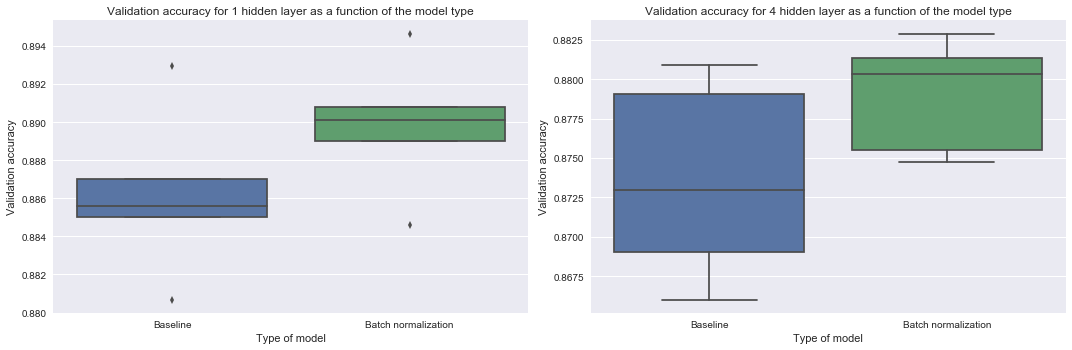

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_baseline.T, val_acc1_bn.T], ax=ax[0])
ax[0].set_title('Validation accuracy for 1 hidden layer as a function of the model type')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Type of model')
ax[0].set_xticklabels(['Baseline', 'Batch normalization'], fontsize=10)

sns.boxplot(data=[val_acc4_baseline.T, val_acc4_bn.T], ax=ax[1])
ax[1].set_title('Validation accuracy for 4 hidden layer as a function of the model type')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('Type of model')
ax[1].set_xticklabels(['Baseline', 'Batch normalization'], fontsize=10)

plt.tight_layout()

plt.show()

#### Only dropout

In this section we try to use the dropout technique to improve the accuracy. All the layers have the same dropout probability which we try to optimize : the values `[0.1, 0.2, 0.3, 0.5, 0.7]` are tested. We average the results over `num_runs = 3` runs to have more robust statistics.

In [17]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 200
input_shape = (16*16,)
optimizer = Adam()
num_runs = 3 #Averaging the results over several runs
dropout_probability = [0.1, 0.2, 0.3, 0.5, 0.7]

**Training the models :**

In [47]:
histories1 = []

for i in range(len(dropout_probability)):
    histories1.append([])
    for j in range(num_runs):
        model = create_model1(dropout=dropout_probability[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories1[i].append(history.history)
        
histories4 = []

for i in range(len(dropout_probability)):
    histories4.append([])
    for j in range(num_runs):
        model = create_model4(dropout=dropout_probability[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories4[i].append(history.history)

In [22]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_obj(histories1, 'ex6_dropout_histories1_200_2')
save_obj(histories4, 'ex6_dropout_histories4_200_2')

In [48]:
histories1 = load_obj('ex6_dropout_histories1_200_2')
histories4 = load_obj('ex6_dropout_histories4_200_2')

histories1_loss =[]
histories1_acc =[]
histories4_loss =[]
histories4_acc =[]

for i in range(len(histories1)):
    histories1_loss.append([])
    histories1_acc.append([])
    histories4_loss.append([])
    histories4_acc.append([])
    for j in range(len(histories1[0])):
        histories1_loss[i].append(histories1[i][j]['val_loss'])
        histories1_acc[i].append(histories1[i][j]['val_acc'])
        histories4_loss[i].append(histories4[i][j]['val_loss'])
        histories4_acc[i].append(histories4[i][j]['val_acc'])
        
histories1_loss = np.array(histories1_loss)
histories1_acc = np.array(histories1_acc)
histories4_loss = np.array(histories4_loss)
histories4_acc = np.array(histories4_acc)

val_loss1_dropout = np.min(histories1_loss, axis=2)
val_acc1_dropout = []
for (j, i) in enumerate(np.argmin(histories1_loss, axis=2)):
    val_acc1_dropout.append(np.diag(np.take(histories1_acc[j],i.tolist(), axis=1)).tolist())
val_acc1_dropout = np.array(val_acc1_dropout)

val_loss4_dropout = np.min(histories4_loss, axis=2)
val_acc4_dropout = []
for (j, i) in enumerate(np.argmin(histories4_loss, axis=2)):
    val_acc4_dropout.append(np.diag(np.take(histories4_acc[j],i.tolist(), axis=1)).tolist())
val_acc4_dropout = np.array(val_acc4_dropout)

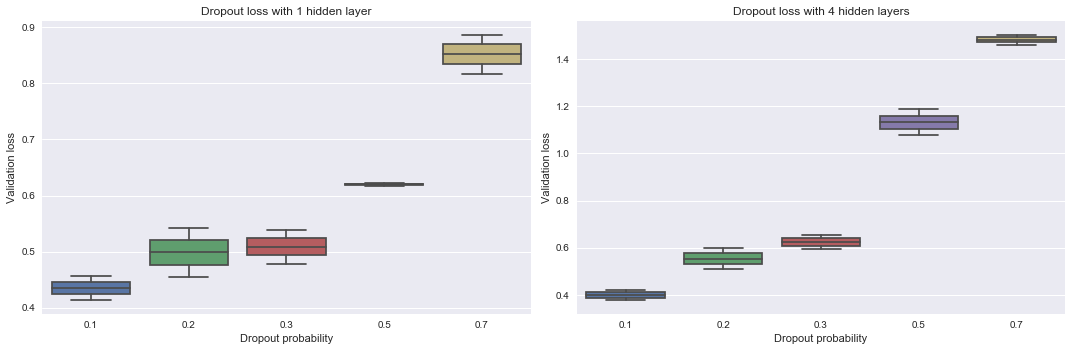

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_loss1_dropout.T, ax=ax[0])
ax[0].set_title('Dropout loss with 1 hidden layer')
ax[0].set_ylabel('Validation loss')
ax[0].set_xlabel('Dropout probability')
ax[0].set_xticklabels(dropout_probability, fontsize=10)

sns.boxplot(data=val_loss4_dropout.T, ax=ax[1])
ax[1].set_title('Dropout loss with 4 hidden layers')
ax[1].set_ylabel('Validation loss')
ax[1].set_xlabel('Dropout probability')
ax[1].set_xticklabels(dropout_probability, fontsize=10)

plt.tight_layout()

plt.show()

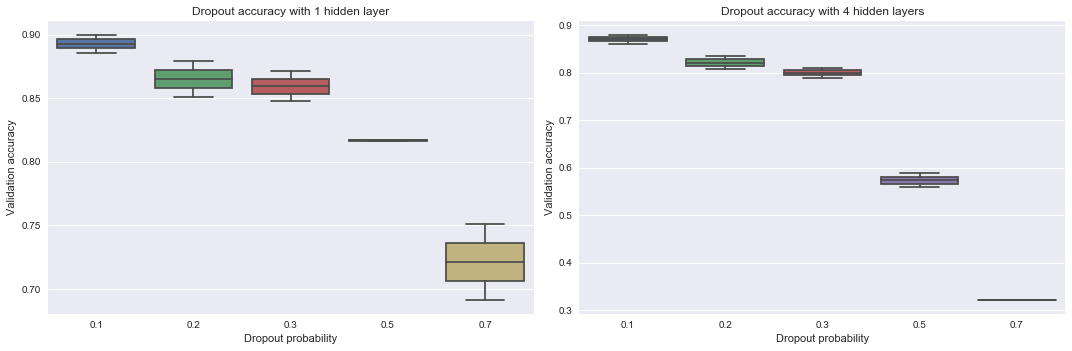

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_acc1_dropout.T, ax=ax[0])
ax[0].set_title('Dropout accuracy with 1 hidden layer')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Dropout probability')
ax[0].set_xticklabels(dropout_probability, fontsize=10)

sns.boxplot(data=val_acc4_dropout.T, ax=ax[1])
ax[1].set_title('Dropout accuracy with 4 hidden layers')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('Dropout probability')
ax[1].set_xticklabels(dropout_probability, fontsize=10)

plt.tight_layout()

plt.show()

The higher the dropout probability is, the worse the predictions are. However it seems like a dropout probability of `0.1` improves the accuracy in the model with 1 hidden layer, but not with 4 hidden layers. The following plot confirms this :

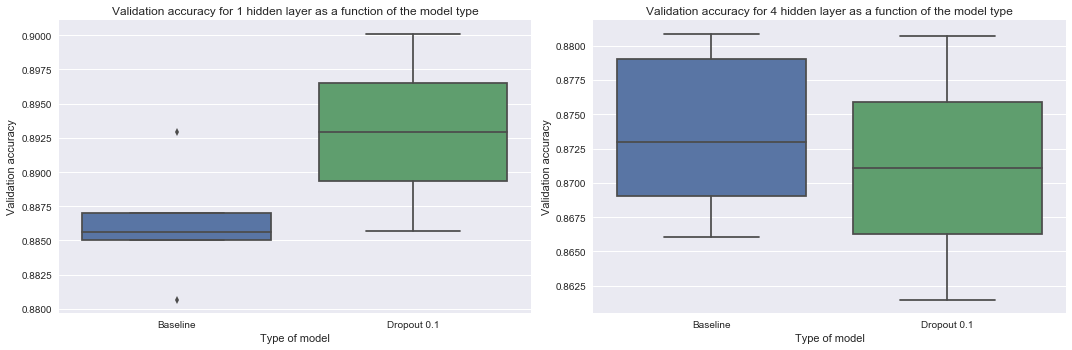

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_baseline.T, val_acc1_dropout[0].T], ax=ax[0])
ax[0].set_title('Validation accuracy for 1 hidden layer as a function of the model type')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Type of model')
ax[0].set_xticklabels(['Baseline', 'Dropout 0.1'], fontsize=10)

sns.boxplot(data=[val_acc4_baseline.T, val_acc4_dropout[0].T], ax=ax[1])
ax[1].set_title('Validation accuracy for 4 hidden layer as a function of the model type')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('Type of model')
ax[1].set_xticklabels(['Baseline', 'Dropout 0.1'], fontsize=10)

plt.tight_layout()

plt.show()

#### L1 regularization only

In this section we are trying to regularize the training of both models (1 hidden layer and 4 hidden layers) with the L1 regularization and compare it to the baseline model.

We will plot both cross entropy loss and accuracy to find the best regularization parameter.

In [38]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 150
input_shape = (16*16,)
optimizer = Adam()
num_runs = 1
regularization_rates = np.logspace(-9,-3,9)[2:]

In [ ]:
histories1 = []
print('1 hidden layer... regularization rate : ')
for i in range(len(regularization_rates)):
    print(regularization_rates[i])
    histories1.append([])
    for j in range(num_runs):
        model = create_model1(l1_rate=regularization_rates[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories1[i].append(history.history)
        
histories4 = []
print('4 hidden layers... regularization rate : ')
for i in range(len(regularization_rates)):
    print(regularization_rates[i])
    histories4.append([])
    for j in range(num_runs):
        model = create_model4(l1_rate=regularization_rates[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories4[i].append(history.history)

1 hidden layer... regularization rate : 
3.16227766017e-08


In [178]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_obj(histories1, 'ex6_l1_new_histories1')
save_obj(histories4, 'ex6_l1_new_histories4')

In [11]:
histories1 = load_obj('ex6_l1_new_histories1')
histories4 = load_obj('ex6_l1_new_histories4')

histories1_loss =[]
histories1_acc =[]
histories4_loss =[]
histories4_acc =[]

for i in range(len(histories1)-1):
    histories1_loss.append([])
    histories1_acc.append([])
    histories4_loss.append([])
    histories4_acc.append([])
    for j in range(len(histories1[0])):
        histories1_loss[i].append(histories1[i][j]['val_loss'])
        histories1_acc[i].append(histories1[i][j]['val_acc'])
        histories4_loss[i].append(histories4[i][j]['val_loss'])
        histories4_acc[i].append(histories4[i][j]['val_acc'])
        
histories1_loss = np.array(histories1_loss)
histories1_acc = np.array(histories1_acc)
histories4_loss = np.array(histories4_loss)
histories4_acc = np.array(histories4_acc)

val_loss1_l1 = np.min(histories1_loss, axis=2)
val_acc1_l1 = []
for (j, i) in enumerate(np.argmin(histories1_loss, axis=2)):
    val_acc1_l1.append(np.diag(np.take(histories1_acc[j],i.tolist(), axis=1)).tolist())
val_acc1_l1 = np.array(val_acc1_l1)

val_loss4_l1 = np.min(histories4_loss, axis=2)
val_acc4_l1 = []
for (j, i) in enumerate(np.argmin(histories4_loss, axis=2)):
    val_acc4_l1.append(np.diag(np.take(histories4_acc[j],i.tolist(), axis=1)).tolist())
val_acc4_l1 = np.array(val_acc4_l1)

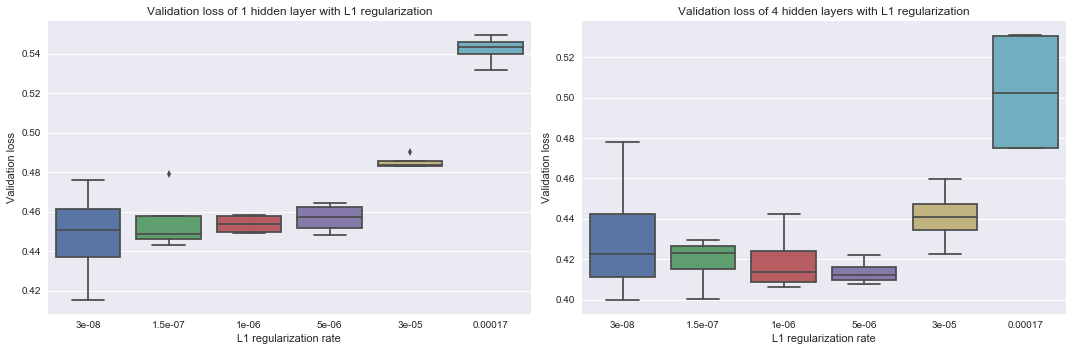

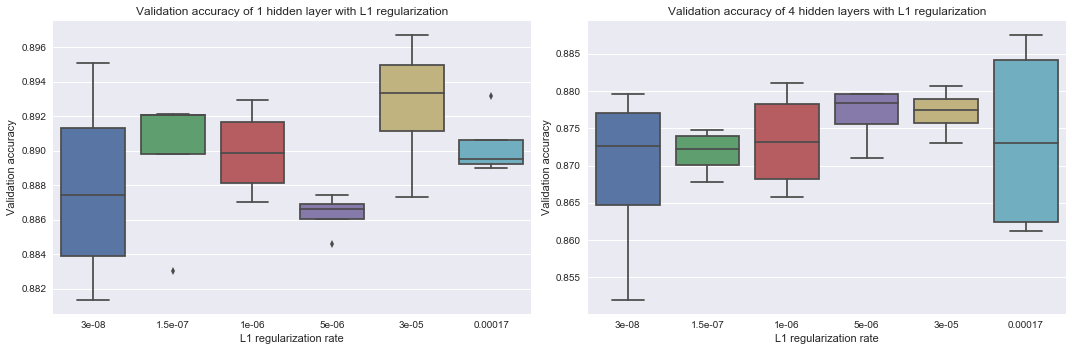

In [12]:
# for the graph
regularization_rates = np.array([3e-08, 1.5e-07, 1e-06, 5e-06, 3e-05, 1.7e-04, 1e-03])

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_loss1_l1.T, ax=ax[0])
ax[0].set_title('Validation loss of 1 hidden layer with L1 regularization')
ax[0].set_ylabel('Validation loss')
ax[0].set_xlabel('L1 regularization rate')
ax[0].set_xticklabels(regularization_rates[:-1], fontsize=10)

sns.boxplot(data=val_loss4_l1.T, ax=ax[1])
ax[1].set_title('Validation loss of 4 hidden layers with L1 regularization')
ax[1].set_ylabel('Validation loss')
ax[1].set_xlabel('L1 regularization rate')
ax[1].set_xticklabels(regularization_rates[:-1], fontsize=10)

plt.tight_layout()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_acc1_l1.T, ax=ax[0])
ax[0].set_title('Validation accuracy of 1 hidden layer with L1 regularization')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('L1 regularization rate')
ax[0].set_xticklabels(regularization_rates, fontsize=10)

sns.boxplot(data=val_acc4_l1.T, ax=ax[1])
ax[1].set_title('Validation accuracy of 4 hidden layers with L1 regularization')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('L1 regularization rate')
ax[1].set_xticklabels(regularization_rates, fontsize=10)

plt.tight_layout()

plt.show()

For regularization rate higher than 1.7e-04 (not on the plots), we reach very high validation loss and low validation accuracy. We decided to focus the graph on regularization rates of interests.

L1 regularization gives better results for 1 hidden layer than baseline (see next plot) with ***l1 regularization rate of 3e-05*** reaching ***0.892 accuracy***. For 4 hidden layers, a best score is achieved with l2.

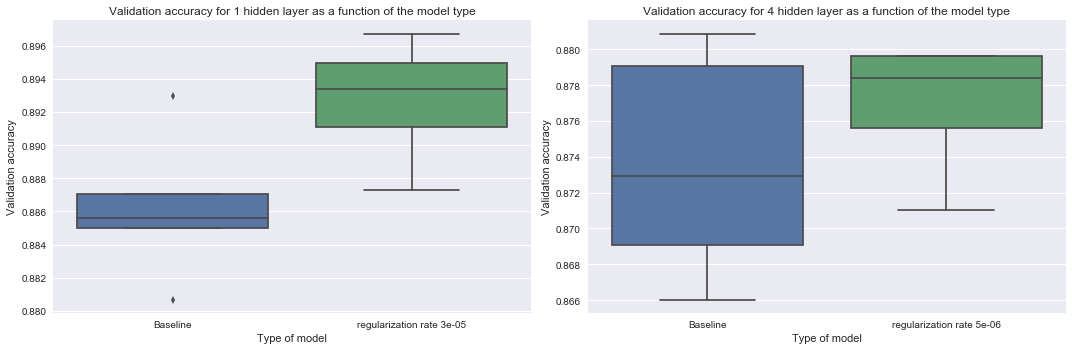

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_baseline.T, val_acc1_l1[4].T], ax=ax[0])
ax[0].set_title('Validation accuracy for 1 hidden layer as a function of the model type')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Type of model')
ax[0].set_xticklabels(['Baseline', 'l1 regularization rate 3e-05'], fontsize=10)

sns.boxplot(data=[val_acc4_baseline.T, val_acc4_l1[3].T], ax=ax[1])
ax[1].set_title('Validation accuracy for 4 hidden layer as a function of the model type')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('Type of model')
ax[1].set_xticklabels(['Baseline', 'l1 regularization rate 5e-06'], fontsize=10)

plt.tight_layout()

plt.show()

#### Regularization L2 only

In this section we are trying to regularize the training of both models (1 hidden layer and 4 hidden layers) with the L2 regularization and compare it to the baseline model.

In [169]:
histories1 = []
print('1 hidden layer... regularization rate : ')
for i in range(len(regularization_rates)):
    print(regularization_rates[i])
    histories1.append([])
    for j in range(num_runs):
        model = create_model1(l2_rate=regularization_rates[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories1[i].append(history.history)
        
histories4 = []
print('4 hidden layers... regularization rate : ')
for i in range(len(regularization_rates)):
    histories4.append([])
    print(regularization_rates[i])
    for j in range(num_runs):
        model = create_model4(l2=regularization_rates[i])
        
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        histories4[i].append(history.history)

1 hidden layer... regularization rate : 
3.16227766017e-08
1.77827941004e-07
4 hidden layers... regularization rate : 
3.16227766017e-08
1.77827941004e-07


In [204]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_obj(histories1, 'ex6_l2_new_histories1')
save_obj(histories4, 'ex6_l2_new_histories4')

In [13]:
histories1 = load_obj('ex6_l2_new_histories1')
histories4 = load_obj('ex6_l2_new_histories4')

histories1_loss =[]
histories1_acc =[]
histories4_loss =[]
histories4_acc =[]

for i in range(len(histories1)):
    histories1_loss.append([])
    histories1_acc.append([])
    histories4_loss.append([])
    histories4_acc.append([])
    for j in range(len(histories1[0])):
        histories1_loss[i].append(histories1[i][j]['val_loss'])
        histories1_acc[i].append(histories1[i][j]['val_acc'])
        histories4_loss[i].append(histories4[i][j]['val_loss'])
        histories4_acc[i].append(histories4[i][j]['val_acc'])
        
histories1_loss = np.array(histories1_loss)
histories1_acc = np.array(histories1_acc)
histories4_loss = np.array(histories4_loss)
histories4_acc = np.array(histories4_acc)

val_loss1_l2 = np.min(histories1_loss, axis=2)
val_acc1_l2 = []
for (j, i) in enumerate(np.argmin(histories1_loss, axis=2)):
    val_acc1_l2.append(np.diag(np.take(histories1_acc[j],i.tolist(), axis=1)).tolist())
val_acc1_l2 = np.array(val_acc1_l2)

val_loss4_l2 = np.min(histories4_loss, axis=2)
val_acc4_l2 = []
for (j, i) in enumerate(np.argmin(histories4_loss, axis=2)):
    val_acc4_l2.append(np.diag(np.take(histories4_acc[j],i.tolist(), axis=1)).tolist())
val_acc4_l2 = np.array(val_acc4_l2)

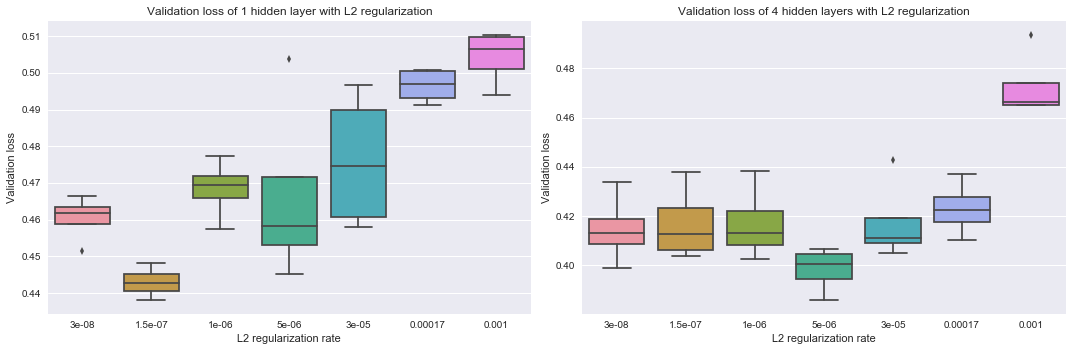

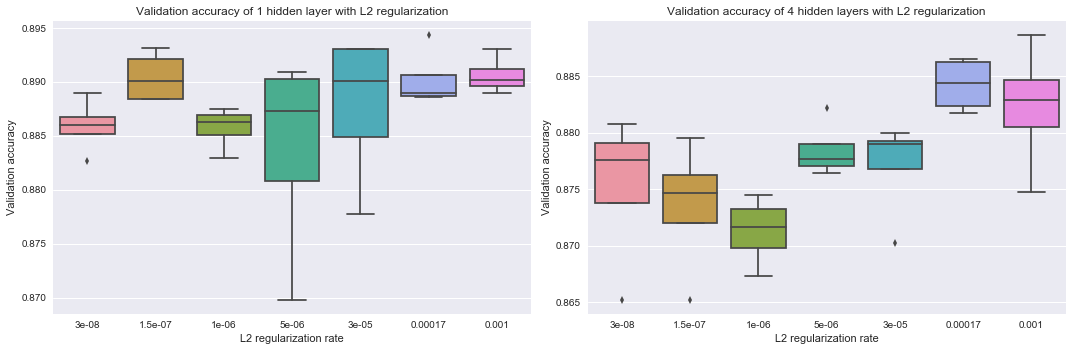

In [14]:
regularization_rates = np.array([3e-08, 1.5e-07, 1e-06, 5e-06, 3e-05, 1.7e-04, 1e-03])
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_loss1_l2.T, ax=ax[0])
ax[0].set_title('Validation loss of 1 hidden layer with L2 regularization')
ax[0].set_ylabel('Validation loss')
ax[0].set_xlabel('L2 regularization rate')
ax[0].set_xticklabels(regularization_rates, fontsize=10)

sns.boxplot(data=val_loss4_l2.T, ax=ax[1])
ax[1].set_title('Validation loss of 4 hidden layers with L2 regularization')
ax[1].set_ylabel('Validation loss')
ax[1].set_xlabel('L2 regularization rate')
ax[1].set_xticklabels(regularization_rates, fontsize=10)

plt.tight_layout()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=val_acc1_l2.T, ax=ax[0])
ax[0].set_title('Validation accuracy of 1 hidden layer with L2 regularization')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('L2 regularization rate')
ax[0].set_xticklabels(regularization_rates, fontsize=10)

sns.boxplot(data=val_acc4_l2.T, ax=ax[1])
ax[1].set_title('Validation accuracy of 4 hidden layers with L2 regularization')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('L2 regularization rate')
ax[1].set_xticklabels(regularization_rates, fontsize=10)

plt.tight_layout()

plt.show()

L2 regularization gives better results than L1 for ***4 hidden layers*** (next plot) : best model is achieved with ***l2 regularization rate of 0.00017*** reaching ***0.885 accuracy***.

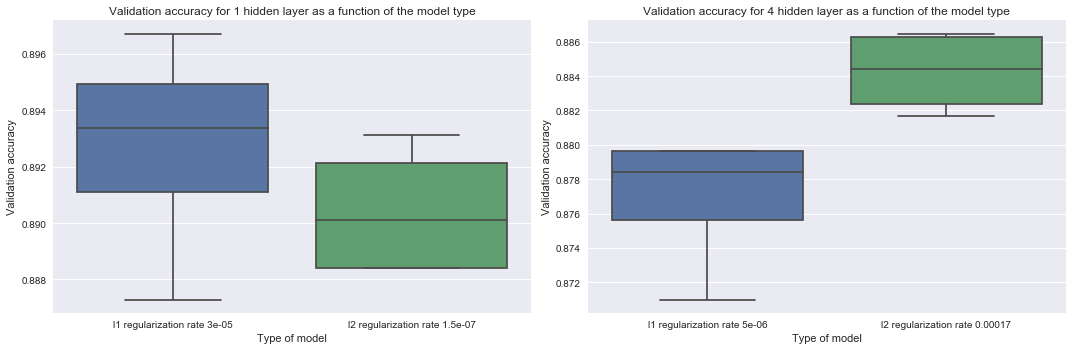

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=[val_acc1_l1[4].T, val_acc1_l2[1].T], ax=ax[0])
ax[0].set_title('Validation accuracy for 1 hidden layer as a function of the model type')
ax[0].set_ylabel('Validation accuracy')
ax[0].set_xlabel('Type of model')
ax[0].set_xticklabels(['l1 regularization rate 3e-05', 'l2 regularization rate 1.5e-07'], fontsize=10)

sns.boxplot(data=[val_acc4_l1[3].T, val_acc4_l2[-2].T], ax=ax[1])
ax[1].set_title('Validation accuracy for 4 hidden layer as a function of the model type')
ax[1].set_ylabel('Validation accuracy')
ax[1].set_xlabel('Type of model')
ax[1].set_xticklabels(['l1 regularization rate 5e-06', 'l2 regularization rate 0.00017'], fontsize=10)

plt.tight_layout()

plt.show()

#### Combined best model

After playing with the different tricks and tuning the hyper parameters, we to combine the best ones in two final models (for 1 and 4 layers) and look at the learning curves.

In [99]:
batch_size = 128
epochs = 250
input_shape = (16*16,)
optimizer = Adam()

For ***1 hidden layer***, we use ***batch normalization***, ***dropout*** and ***L1 regularization rate 3e-05***.

In [73]:
model = create_model1(bn=True, dropout=0.1, l1_rate=3e-05)
        
model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )

save_history(history, 'ex6_1_layer_best')

For ***4 hidden layer***, we discoverd experimentally that models with dropout are giving far better results than without, avoiding high overfitting. We use here ***batch normalization***, ***dropout*** and ***L2 regularization rate 0.00017***

In [101]:
model = create_model4(bn=True , dropout=0.1, l2_rate=0.00017)
        
model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

history_4_layers = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )

save_history(history_4_layers, 'ex6_4_layer_best')

We compare ***both*** learning curves on the same graph

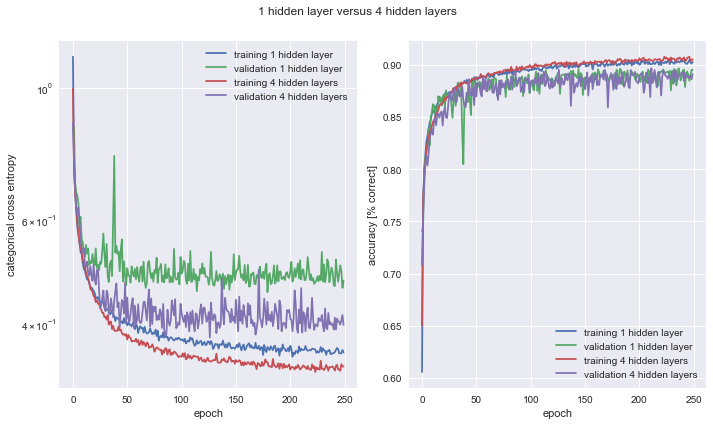

In [127]:
history_1_layer = load_history('ex6_1_layer_best')
history_4_layers = load_history('ex6_4_layer_best')

plot = plot_dict_histories(history_1_layer, history_4_layers, '1 hidden layer', '4 hidden layers')

We reach the same accuracy level with both models, however cross entropy error is better for model with ***4 hidden layers***. Therefore the best model is with 4 hidden layers, that could even give better accuracy results with more epochs.

Let's now compare ***4 hidden layers*** with our last best model (exercise 4), which is ***1 hidden layer of 500 neurons***

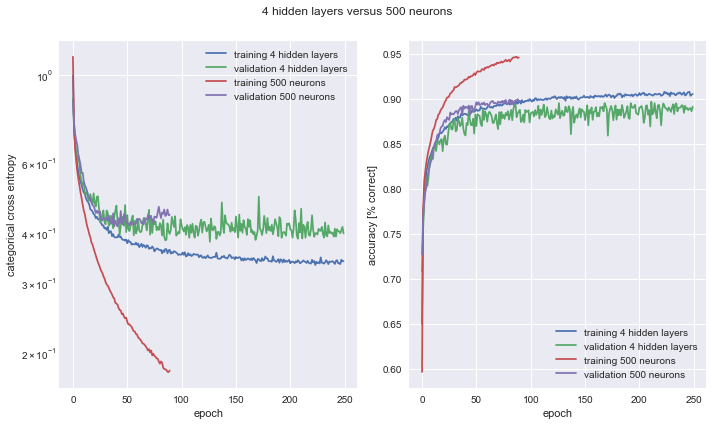

In [130]:
history_500 = load_history('ex_4_500_neurons')
plot = plot_dict_histories(history_4_layers, history_500, '4 hidden layers', '500 neurons')

Convergence of model with 500 neurons is very fast, but we have a better error with 4 hidden layers and reach almost same validation accuracy. We would prefer the model with ***4 hidden layers*** for its better cross entropy loss.

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

### Question 1

Several structures are possible for the CNN (number of 2D convolutions, kernel size, number of filters...) and all the tricks described in the exercise 6 can also be used. First we train a basic CNN with 2 convolutions over 20 epochs to see how well it performs. Then we try to improve the accuracy.

For an input shape of $16\times16$ and a few ten thousands examples, two convolutions are usually enough to get near optimal performances. Using `kernel_size = (5, 5)` and `pool_size = (2, 2)` fits the input shape and are standard values. Moreover we use `num_filters1 = 32` filters for the first convolution and `num_filters2 = 64` for the second one : it is a good compromise to train the model quickly and having a good accuracy.

In [13]:
"""
Parameters
"""

batch_size = 128
input_shape = (16, 16, 1)
num_classes = len(subset_of_classes)
num_filters1 = 32
num_filters2 = 64
kernel_size = (5, 5)
pool_size = (2, 2)
optimizer = Adam()
epochs = 20

In [18]:
"""
Basic model architecture with 2 convolutions
"""
    
model = Sequential()

model.add(Conv2D(input_shape=input_shape,
                 filters=num_filters1,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Conv2D(filters=num_filters2,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')
         )

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Flatten())
    
model.add(Dense(1024, activation='relu'))
              
model.add(Dropout(0.4))
    
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

num_train_images = x_train.shape[0]
x_train_reshaped = x_train.reshape(num_train_images, 16, 16, 1)
y_train_reshaped = y_train
num_test_images = x_test.shape[0]
x_test_reshaped = x_test.reshape(num_test_images, 16, 16, 1)
y_test_reshaped = y_test

model.fit(x_train_reshaped, y_train_reshaped,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_reshaped, y_test_reshaped)
         )

evaluate = model.evaluate(x_test_reshaped, y_test_reshaped, verbose=0)

print('This basic model performs a validation loss of {0} and a validation accuracy of {1}%.'
      .format(np.round(evaluate[0], 3), np.round(100*evaluate[1], 3)))

This basic model performs a validation loss of 0.273 and a validation accuracy of 94.201%.


We outperform the so far best model by about ***4% accuracy*** for the validation set. By playing with different models and adding some tricks, we found out that using this architecture with 0.5-dropouts, and training it over 75 epochs, gives a little more than ***96% accuracy*** on the validation set. This is so far the best model we have.

In [13]:
"""
Parameters
"""
batch_size = 128
input_shape = (16, 16, 1)
num_classes = len(subset_of_classes)
num_filters1 = 32
num_filters2 = 64
kernel_size = (5, 5)
pool_size = (2, 2)
optimizer = Adam()
epochs = 75

In [14]:
"""
Basic model architecture with 2 convolutions
"""
model = Sequential()

model.add(Conv2D(input_shape=input_shape,
                 filters=num_filters1,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu'))

model.add(Dropout(0.5))

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Conv2D(filters=num_filters2,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')
         )

model.add(Dropout(0.5))

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Flatten())
    
model.add(Dense(1024, activation='relu'))
              
model.add(Dropout(0.4))
    
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

num_train_images = x_train.shape[0]
x_train_reshaped = x_train.reshape(num_train_images, 16, 16, 1)
y_train_reshaped = y_train
num_test_images = x_test.shape[0]
x_test_reshaped = x_test.reshape(num_test_images, 16, 16, 1)
y_test_reshaped = y_test

history = model.fit(x_train_reshaped, y_train_reshaped,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_reshaped, y_test_reshaped)
                   )

In [19]:
"""
Saving the history. /!\ Do not run it unless you want to override it.
"""
save_history(history, 'ex7_base_dropout0_5')

We get an optimal validation accuracy of about ***96.4%***. The loss curves show that the model isn't overfitting but training it over more epochs doesn't seem to be profitable (no improvement after 50 epochs).

This model performs an accuracy of 96.446% !


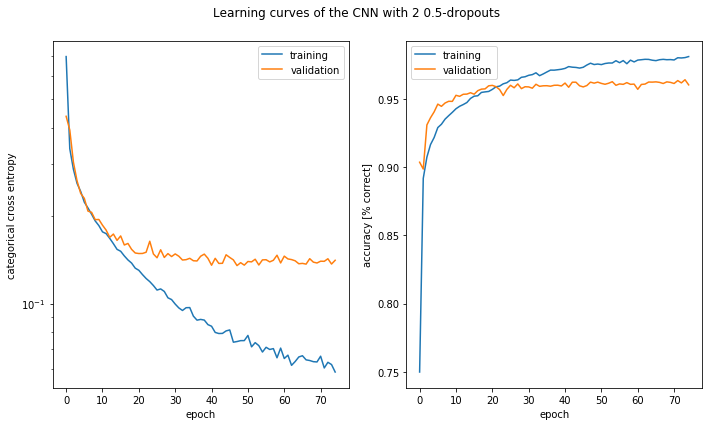

In [15]:
history = load_obj('ex7_base_dropout0_5')

plot = plot_dict_history(history, 'Learning curves of the CNN with 2 0.5-dropouts')

print('This model performs an accuracy of {}% !'.format(np.round(100*np.max(history['val_acc']), 3)))

### Question 2

We plot here the learning curves of the best CNN model with the 2 best models we have so far found in the exercise 6 : the one with 1 hidden layer and the one with 4 hidden layers. Both of them have almost the same performances. These plots show that the CNN clearly outperforms the two best standard neural networks we had so far, with only 75 epochs.

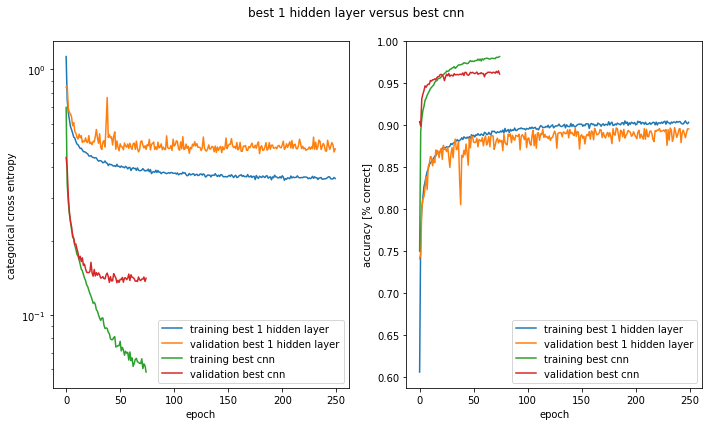

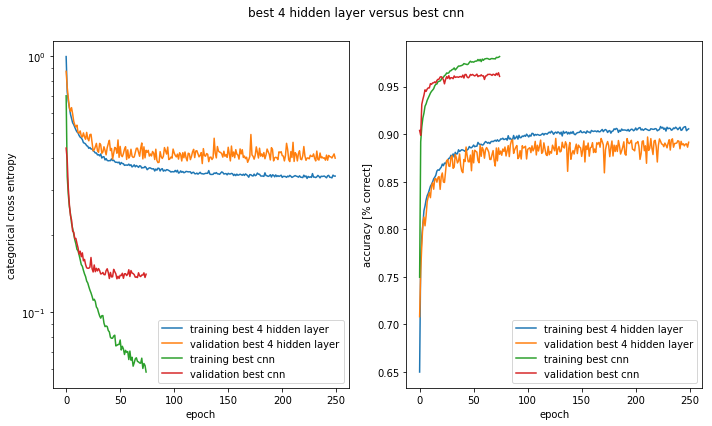

In [23]:
best_1_layer = load_history('ex6_1_layer_best')
best_4_layers = load_history('ex6_4_layer_best')
best_cnn = load_obj('ex7_base_dropout0_5')

plot = plot_dict_histories(best_1_layer, best_cnn, 'best 1 hidden layer', 'best cnn')
plot = plot_dict_histories(best_4_layers, best_cnn, 'best 4 hidden layer', 'best cnn')